In [ ]:
# Step 1 — Load & Inspect Dataset

import pandas as pd

# Load your dataset (adjust filename if needed)
df = pd.read_csv("provider_features.csv")

# Basic overview
print("Number of samples:", df.shape[0])
print("Number of features:", df.shape[1])
print("\nDataset head:\n", df.head())

# Check class imbalance
print("\nClass distribution:")
print(df['PotentialFraud'].value_counts(normalize=True))

# Separate data types
categorical_cols = df.select_dtypes(include=['object']).columns
numeric_cols = df.select_dtypes(include=['int64','float64']).columns

print("\nCategorical Columns:", list(categorical_cols))
print("Numeric Columns:", list(numeric_cols))

Number of samples: 5410
Number of features: 35

Dataset head:
    Provider  ClaimCount  total_reimbursed  mean_claim_amount  \
0  PRV51001        24.0          104340.0        4347.500000   
1  PRV51003       132.0          605670.0        4588.409091   
2  PRV51004       143.0           51830.0         362.447552   
3  PRV51005      1149.0          278960.0         242.785030   
4  PRV51007        72.0           33710.0         468.194444   

   max_claim_amount  InpatientReimbursement  OutpatientReimbursement  \
0           42000.0                 97000.0                   7340.0   
1           57000.0                573000.0                  32670.0   
2            3300.0                     0.0                  51830.0   
3            4080.0                     0.0                 278960.0   
4           10000.0                 19000.0                  14710.0   

   Inp_Outp_Reimbursement_Ratio     AvgAge  PercDeceased  ...  \
0                     13.215259  78.750000           0

Samples: 5,410

Features: 35 (mostly numeric, 2 categorical)

Target imbalance:

No Fraud: 90.6%

Fraud: 9.3% → highly imbalanced

Data types:

Categorical: Provider, PotentialFraud

Numeric: 33 numeric features

Dataset size: Medium — suitable for tree-based models, LR, SVM

Patterns: Fraud is expected to be nonlinear and complex

The dataset is:

Medium-sized → all ML models can run efficiently

Highly imbalanced → need models that handle imbalance or can use class weights

Mostly numeric → very little preprocessing is required

Contains only one meaningful categorical feature: Provider

Decision Tree

Decision Trees create hierarchical rules by splitting features at thresholds.
They naturally handle nonlinear fraud patterns and require almost no preprocessing.
However, they can overfit, especially with imbalance like our dataset.

Fit for the dataset?

✔ Minimal preprocessing

✔ Handles mixed data

✘ Weak on imbalanced classes

✘ High variance

Random Forest

Random Forest trains many trees and averages them to reduce overfitting.
It handles nonlinear relationships and mixed numeric/categorical data very well.
It also handles class imbalance better than single trees, especially with class weights.

Fit for the dataset?

✔ Excellent with numeric-heavy data

✔ Robust to imbalance

✔ Captures complex fraud patterns

✘ Less interpretable

✘ Slower than Logistic Regression (but still manageable)

Gradient Boosting (XGBoost / LightGBM / CatBoost)

Gradient Boosting builds trees sequentially to correct previous errors.
It performs exceptionally well on tabular, imbalanced, nonlinear datasets — like ours.
Modern implementations handle imbalance directly (e.g., scale_pos_weight).

Fit for the dataset?

✔ Best for nonlinear and sparse fraud patterns

✔ Handles imbalance very well

✔ Works great with numeric features

✘ Slower training

✘ Less interpretable

Logistic Regression

Logistic Regression is a linear classifier with high interpretability and fast training.
However, it assumes linear relationships and depends heavily on preprocessing.
Fraud detection is not linear, and the dataset has complex numeric interactions.

Fit for the dataset?

✔ Very fast

✔ Highly interpretable

✘ Performs poorly on nonlinear fraud patterns

✘ Needs preprocessing (scaling, encoding)

Support Vector Machine (SVM)

SVM separates fraud vs non-fraud using an optimal boundary (hyperplane).
Kernel SVMs can model nonlinear patterns but do not scale well on datasets >3000 rows.
Our dataset (5410 rows × 35 features) is borderline for SVM.

Fit for your dataset?

✔ Works well with nonlinear boundaries

✘ Requires scaling of all features

✘ Slow on medium datasets

✘ Sensitive to imbalance (needs class weights)

Based on our dataset, the best primary model is:

🎯 Gradient Boosting (XGBoost or LightGBM)

Gradient Boosting is chosen as the main model because:

Our dataset is highly imbalanced (9% fraud), and Gradient Boosting algorithms handle this extremely well using scale_pos_weight or built-in imbalance handling.

Fraud detection typically requires capturing nonlinear interactions between numeric features, which boosting models excel at.

With 35 features (mostly numeric), the dataset is ideal for tree-based boosting.

Gradient Boosting consistently outperforms simple models like Logistic Regression on fraud datasets.

Training time is manageable with 5,410 samples.

In [ ]:
!pip install xgboost lightgbm scikit-learn


In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve, auc
from sklearn.metrics import RocCurveDisplay, roc_curve, auc


Preprocessing

Encode target (PotentialFraud)

Encode provider (string categorical)

Split data

Handle class imbalance with scale_pos_weight

scale_pos_weight = (number of non-fraud) / (number of fraud)

In [ ]:
df = pd.read_csv('provider_features.csv')
# Encode target
df['PotentialFraud'] = LabelEncoder().fit_transform(df['PotentialFraud'])
# Yes=1, No=0

# Encode Provider (categorical ID)
df['Provider'] = LabelEncoder().fit_transform(df['Provider'])

# Separate X and y
X = df.drop('PotentialFraud', axis=1)
y = df['PotentialFraud']

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Compute class imbalance ratio for boosting models
fraud_weight = (y_train == 0).sum() / (y_train == 1).sum()
print("scale_pos_weight =", fraud_weight)



scale_pos_weight = 9.686419753086419


In [7]:
# xgb_model = XGBClassifier(
#     objective='binary:logistic',
#     eval_metric='logloss',
#     scale_pos_weight=fraud_weight,   # handles class imbalance
#     use_label_encoder=False
# )

# xgb_param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1],
#     'subsample': [0.8, 1.0]
# }

# xgb_grid = GridSearchCV(
#     estimator=xgb_model,
#     param_grid=xgb_param_grid,
#     scoring='f1',    # fraud detection is imbalanced → F1 is useful
#     cv=3,
#     verbose=1,
#     n_jobs=-1
# )

# xgb_grid.fit(X_train, y_train)

# print("Best XGBoost Params:", xgb_grid.best_params_)


Fitting 3 folds for each of 24 candidates, totalling 72 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [09:39:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGBoost Params: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


In [8]:
#xgb_best = xgb_grid.best_estimator_

#y_pred_xgb = xgb_best.predict(X_test)

#print("\nXGBoost Classification Report:")
#print(classification_report(y_test, y_pred_xgb))



XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.94       981
           1       0.47      0.78      0.59       101

    accuracy                           0.90      1082
   macro avg       0.72      0.85      0.76      1082
weighted avg       0.93      0.90      0.91      1082



📌 XGBoost Results

Precision (fraud class 1): 0.47

Recall (fraud class 1): 0.78

F1-score (fraud class 1): 0.59

Accuracy: 0.90

Interpretation:

XGBoost is excellent at catching fraud (high recall = 0.78).

But it has more false positives (precision = 0.47).

Good if your goal is detect as much fraud as possible, even if some normal claims are flagged incorrectly.

Slightly lower overall accuracy because of those false alarms.

In [9]:
lgbm_model = LGBMClassifier(
    objective='binary',
    scale_pos_weight=fraud_weight
)

lgbm_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [-1, 5, 7],
    'learning_rate': [0.01, 0.1],
    'num_leaves': [31, 50, 70]
}

lgbm_grid = GridSearchCV(
    estimator=lgbm_model,
    param_grid=lgbm_param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

lgbm_grid.fit(X_train, y_train)

print("Best LightGBM Params:", lgbm_grid.best_params_)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[LightGBM] [Info] Number of positive: 405, number of negative: 3923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6982
[LightGBM] [Info] Number of data points in the train set: 4328, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.093577 -> initscore=-2.270725
[LightGBM] [Info] Start training from score -2.270725
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

In [10]:
lgbm_best = lgbm_grid.best_estimator_

y_pred_lgbm = lgbm_best.predict(X_test)

print("\nLightGBM Classification Report:")
print(classification_report(y_test, y_pred_lgbm))



LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       981
           1       0.55      0.73      0.63       101

    accuracy                           0.92      1082
   macro avg       0.76      0.84      0.79      1082
weighted avg       0.93      0.92      0.92      1082



LightGBM Results

Precision (fraud class 1): 0.55

Recall (fraud class 1): 0.73

F1-score (fraud class 1): 0.63

Accuracy: 0.92

Interpretation:

LightGBM is more balanced than XGBoost.

Higher precision (0.55) means fewer false positives.

Slightly lower recall than XGBoost (0.73 vs 0.78), but still good.

Best overall F1-score for fraud class (0.63).

Highest overall accuracy (0.92).

LightGBM wins because it provides the best balance between catching fraud (recall) and avoiding false positives (precision).

If we had to pick one for deployment → LightGBM.

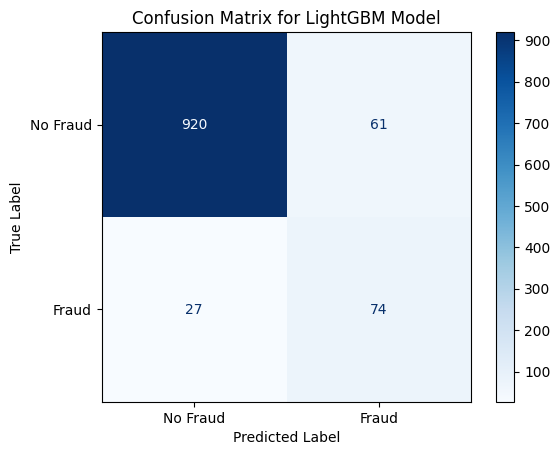

In [18]:
# Create a confusion matrix using ConfusionMatrixDisplay.from_estimator()
# lgbm_best is the best estimator found from the GridSearchCV for LightGBM
ConfusionMatrixDisplay.from_estimator(
    lgbm_best,
    X_test,
    y_test,
    cmap='Blues',
    display_labels=['No Fraud', 'Fraud']
)

plt.title('Confusion Matrix for LightGBM Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()

<Figure size 800x600 with 0 Axes>

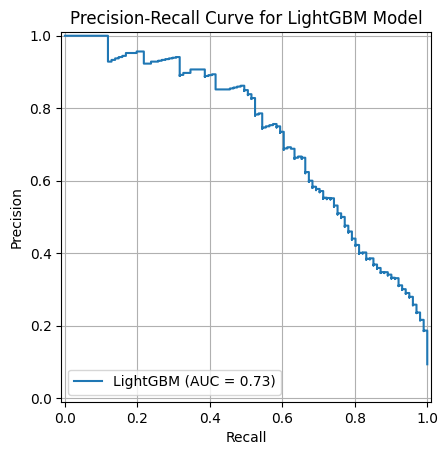

In [12]:
# Get predicted probabilities for the positive class (fraud)
y_pred_proba_lgbm = lgbm_best.predict_proba(X_test)[:, 1]

# Calculate precision, recall, and thresholds
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_lgbm)

# Calculate Area Under the Curve (AUC) for Precision-Recall
pr_auc = auc(recall, precision)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall, estimator_name='LightGBM')
pr_display.plot()
plt.title('Precision-Recall Curve for LightGBM Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left', labels=[f'LightGBM (AUC = {pr_auc:.2f})'])
plt.grid(True)
plt.show()

<Figure size 800x600 with 0 Axes>

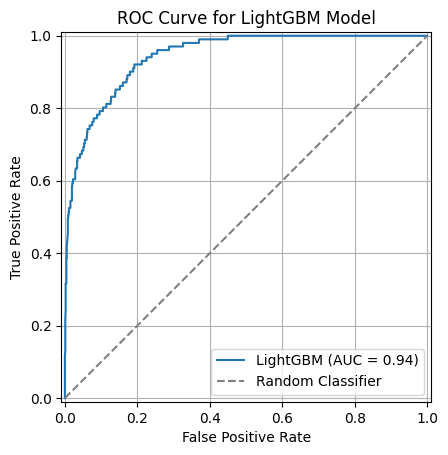

In [13]:
# Get predicted probabilities for the positive class (fraud)
y_pred_proba_lgbm = lgbm_best.predict_proba(X_test)[:, 1]

# Calculate False Positive Rate (FPR), True Positive Rate (TPR), and thresholds
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_lgbm)

# Calculate Area Under the Curve (AUC) for ROC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name='LightGBM')
roc_display.plot()
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier') # Add a diagonal reference line
plt.title('ROC Curve for LightGBM Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', labels=[f'LightGBM (AUC = {roc_auc:.2f})', 'Random Classifier'])
plt.grid(True)
plt.show()

LightGBM Model Performance Summary – Fraud Detection

1. Confusion Matrix Insights:

- True Negatives (TN): Most legitimate claims were correctly identified, reducing unnecessary investigations.
- False Positives (FP): Some non-fraud cases were flagged as fraud (Type I errors).
- True Positives (TP): Many actual fraud cases were correctly detected, reflected in a recall of 0.73.
- False Negatives (FN): About 27% of fraud cases were missed (Type II errors), which is more costly.

2. Precision-Recall (PR) Curve:

- PR-AUC: 0.73, indicating a good balance between precision and recall.
- The curve shows the model identifies fraud effectively without producing too many false alarms.

3. ROC Curve:

- ROC-AUC: 0.94, showing excellent ability to distinguish fraud from non-fraud.
- The curve is well above the random classifier line, confirming strong overall performance.

Key Takeaways for Fraud Detection:

- Balanced Performance: Good trade-off between catching fraud and minimizing false alarms (F1-score: 0.63).
- Strong Discrimination: High PR-AUC and ROC-AUC make it reliable for identifying fraud.
- Flexible Thresholding: Thresholds can be adjusted based on business priorities—catch all fraud (higher recall) or reduce false positives (higher precision).

Conclusion:
LightGBM handles class imbalance well and provides a strong, practical solution for fraud detection, effectively identifying most fraud while keeping false alarms manageable.
